### Step 1

Importing Libraries

In [1]:
import warnings
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')
from io import StringIO
import requests

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

### Step 2

Importing the dataset

In [3]:
sales_data = pd.read_csv("Dataset/Tractor-Sales.csv")

### Step 3

**Data Prepaparion**
   - Make sure that the data has a continious Time Period in the same format
   - Missing Value Treatment
   - Outlier Treatment
   - Making the data indexed with Time (Making it to be Time Series data)

##### Making the data indexed with Time (Making it to be Time Series data)

In [4]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [5]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [6]:
### Removing the original Month-Year variable
del sales_data['Month-Year']

In [7]:
### Renaming the Y variable
sales_data.columns = ['Tractor-Sales']

In [8]:
#### Converting it to a Series
sales_ts = sales_data['Tractor-Sales']

In [9]:
sales_ts

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
             ... 
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Freq: MS, Name: Tractor-Sales, Length: 144, dtype: int64

## Decomposition

In [10]:
sm.tsa.seasonal_decompose?

In [11]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative',two_sided=False, extrapolate_trend=4)

In [12]:
decomposition.resid

2003-01-01    1.028907
2003-02-01    1.099557
2003-03-01    1.074350
2003-04-01    1.078424
2003-05-01    1.007438
                ...   
2014-08-01    1.078833
2014-09-01    1.038754
2014-10-01    1.071776
2014-11-01    1.038297
2014-12-01    1.018544
Freq: MS, Name: resid, Length: 144, dtype: float64

In [13]:
decomposition.seasonal

2003-01-01    0.823508
2003-02-01    0.853891
2003-03-01    1.024830
2003-04-01    1.092962
2003-05-01    1.187805
                ...   
2014-08-01    1.222687
2014-09-01    0.950868
2014-10-01    0.829943
2014-11-01    0.760143
2014-12-01    0.898956
Freq: MS, Name: seasonal, Length: 144, dtype: float64

In [14]:
decomposition.trend

2003-01-01    166.408333
2003-02-01    167.216667
2003-03-01    168.025000
2003-04-01    168.833333
2003-05-01    169.641667
                 ...    
2014-08-01    642.875000
2014-09-01    647.958333
2014-10-01    653.166667
2014-11-01    657.583333
2014-12-01    660.750000
Freq: MS, Name: trend, Length: 144, dtype: float64

In [15]:
### Creating a df with the 3 components
decomp_output = pd.DataFrame(pd.concat([decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], axis=1))
decomp_output.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']

In [16]:
### Getting the original values
decomp_output['Recalculated_Sales'] = decomp_output.Trend*decomp_output.Seasonal*decomp_output.Irregular

#### TASK: <u> Use Decomposition to forecats the next year (12 month) </u>

## ARIMA

### Step 0: Basic Data Preparation
   - Make sure that the data has a continious Time Period in the same format
   - Missing Value Treatment
   - Outlier Treatment
   - Making the data indexed with Time (Making it to be Time Series data)

### Step 1
Check if the data has seasonality or not

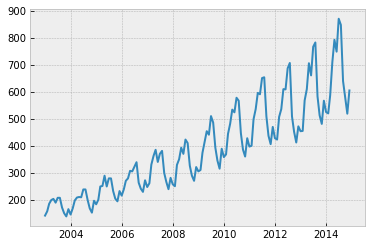

In [17]:
plt.plot(sales_ts)
plt.show()

### Step 2
Check if the data is stationary or not using ADF Test (and then identifying the best value of I)

In [18]:
# Perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

In [19]:
# Perform Dickey-Fuller test (Making the output more readable)
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


#### Step 2.1
Identifying how the data becomes stationary (i.e. finding the best value of I for ARIMA)

##### Try1: Taking Log10

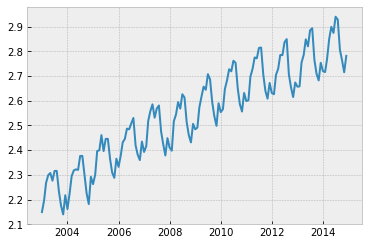

In [20]:
sales_ts_log = np.log10(sales_ts)
plt.plot(sales_ts_log)

In [21]:
# Perform Dickey-Fuller test (using log10)
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.732472
p-value                          0.414464
#lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


##### Try2: Taking Differencing of 1

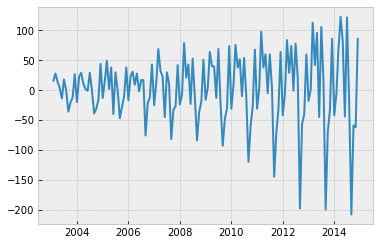

In [22]:
sales_ts_diff1 = sales_ts.diff(1)
sales_ts_diff1.dropna(inplace=True)
plt.plot(sales_ts_diff1)
plt.show()

In [23]:
# Perform Dickey-Fuller test (using diff_1)
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.543481
p-value                          0.105250
#lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


##### Try3: Taking Log10 + Differencing of 1

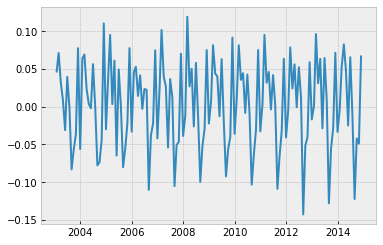

In [24]:
sales_ts_log_diff1 = sales_ts_log.diff(1)
sales_ts_log_diff1.dropna(inplace=True)
plt.plot(sales_ts_log_diff1)
plt.show()

In [25]:
# Perform Dickey-Fuller test (using log10 + diff_1)
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.680467
p-value                          0.077480
#lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


##### Try4: Taking Log10 + Differencing of 2

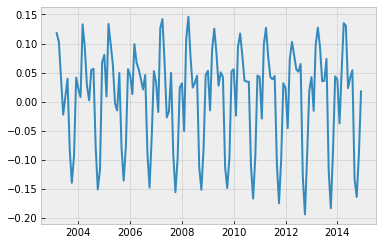

In [26]:
sales_ts_log_diff2 = sales_ts_log.diff(2)
sales_ts_log_diff2.dropna(inplace=True)
plt.plot(sales_ts_log_diff2)
plt.show()

In [27]:
# Perform Dickey-Fuller test (using log10 + diff_2)
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log_diff2)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.200722
p-value                          0.019943
#lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


##### Try5: Taking Differencing of 3

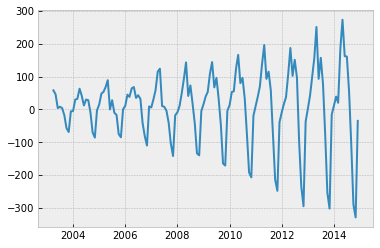

In [28]:
sales_ts_diff3 = sales_ts.diff(3)
sales_ts_diff3.dropna(inplace=True)
plt.plot(sales_ts_diff3)
plt.show()

In [29]:
# Perform Dickey-Fuller test (using diff_3)
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_diff3)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.936724
p-value                          0.041241
#lags Used                      10.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Step 3
Check if the data is a Random Walk or not using ACF and PACF (Also finding the best value of P and Q)

C:\Users\Archish\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


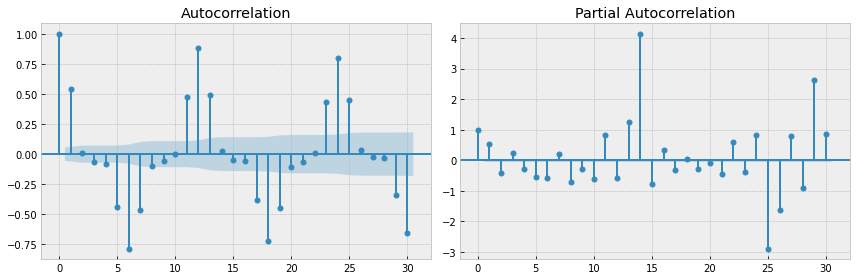

In [30]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff2, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff2, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

In [31]:
from statsmodels.tsa.arima.model import ARIMA

In [32]:
# initiate and fit model
model = ARIMA(sales_ts_log, order=(2,2,1))
model_fit = model.fit()

C:\Users\Archish\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Tractor-Sales   No. Observations:                  144
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 205.439
Date:                Sat, 18 Dec 2021   AIC                           -402.878
Time:                        15:21:34   BIC                           -391.055
Sample:                    01-01-2003   HQIC                          -398.074
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1391      0.116      1.199      0.231      -0.088       0.366
ar.L2         -0.0372      0.133     -0.279      0.780      -0.299       0.224
ma.L1         -1.0000     31.704     -0.032      0.9

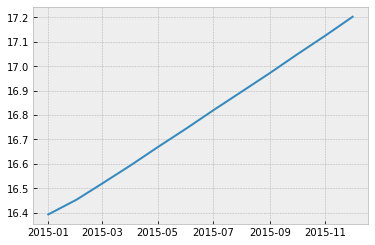

In [34]:
### Forecasting for the next 12 Time Period
plt.plot(np.exp(model_fit.forecast(12)))

## SARIMA

##### If to run SARIMA by finding p,d,q and P,D,Q manually-

In [35]:
model = sm.tsa.statespace.SARIMAX(sales_ts_log, order = (2,2,1), seasonal_order= (1,0,0,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

results = model.fit()

print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                       Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(2, 2, 1)x(1, 0, [], 12)   Log Likelihood                 326.522
Date:                             Sat, 18 Dec 2021   AIC                           -643.044
Time:                                     15:21:36   BIC                           -628.783
Sample:                                 01-01-2003   HQIC                          -637.250
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3437      0.079     -4.365      0.000      -0.498      -0.189
ar.L2          0.0006      

C:\Users\Archish\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### If to run SARIMA by using a loop and let it find the best values of p,d,q and P,D,Q
(Kind of like a manually created Grid Search - Hyper Parameter Tuning)

In [36]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(2,3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [37]:
# Generate all different combinations of seasonal p, q and q triplets
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [38]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 2, 1)x(1, 0, 1, 12)12 model - AIC:-673.2933429897091


In [39]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(1, 2, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

#### Performing forecasting visually

In [40]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [41]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [42]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,564.642360,524.804990,607.503741,524.804990,607.503741
2015-01-01,562.716747,515.631344,614.101802,515.631344,614.101802
2015-02-01,668.759472,602.318744,742.529160,602.318744,742.529160
2015-03-01,756.662280,672.369251,851.522888,672.369251,851.522888
2015-04-01,854.604913,749.736385,974.141807,749.736385,974.141807


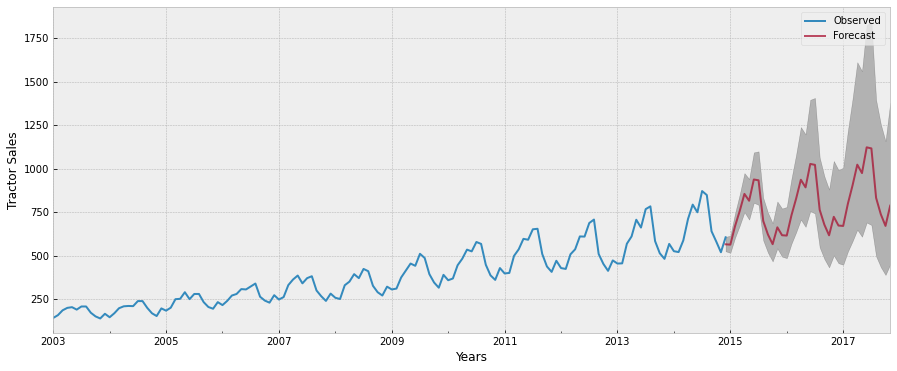

In [43]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

## ARIMAX / SARIMAX

In [44]:
### Importing the data

mkt_sales_data = pd.read_csv('dataset/sales-and-marketing.csv')

In [45]:
### Making the data time indexed

# since the complete date was not mentioned, we assume that it was the first of every month
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


In [46]:
### Doing a differencing of 1
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data_diff['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.015650e+00
p-value                        6.743731e-10
#lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


In [47]:
### Checking the correlation of X, X-1, X-2, X-3 ... with the Y

In [48]:
mkt_sales_data['Mkt_Exp_Lag_1'] = mkt_sales_data['Marketing Expense'].shift(1)
mkt_sales_data['Mkt_Exp_Lag_2'] = mkt_sales_data['Marketing Expense'].shift(2)
mkt_sales_data['Mkt_Exp_Lag_3'] = mkt_sales_data['Marketing Expense'].shift(3)
mkt_sales_data['Mkt_Exp_Lag_4'] = mkt_sales_data['Marketing Expense'].shift(4)

In [49]:
mkt_sales_data.dropna(inplace=True)
mkt_sales_data.head()

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
2011-05-01,596,744.15,565.16,437.09,501.80,486.64
2011-06-01,591,548.74,744.15,565.16,437.09,501.80
2011-07-01,651,650.21,548.74,744.15,565.16,437.09
2011-08-01,654,777.51,650.21,548.74,744.15,565.16
2011-09-01,509,547.11,777.51,650.21,548.74,744.15


In [50]:
mkt_sales_data.corr().head(1)

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
Tractor-Sales,1.0,0.807838,0.585169,0.262011,-0.056909,-0.257012


In [51]:
#### Finding the best value of p,d,q and P,D,Q

In [52]:
import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 2), q=range(0, 2),
              P=range(0, 2), D=range(0, 1), Q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
                
                

    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [53]:
### Running the function

In [54]:
#ARIMA Model with 2 months Lag Marekting Sales Data Regressor
timeseries = mkt_sales_data["Tractor-Sales"]
regressors = mkt_sales_data[["Marketing Expense", "Mkt_Exp_Lag_1", "Mkt_Exp_Lag_2"]]

In [55]:
best_results = auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 2), q=range(0, 2),
                         P=range(0, 2), D=range(0, 1), Q=range(0, 2))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:273.4843871799599
                                     SARIMAX Results                                      
Dep. Variable:                      Tractor-Sales   No. Observations:                   44
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -129.742
Date:                            Sat, 18 Dec 2021   AIC                            273.484
Time:                                    15:22:48   BIC                            283.055
Sample:                                05-01-2011   HQIC                           276.482
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Marketing Expense     0.0287    

In [56]:
#### Manually creating the model again with the best identified values of p,d,q and P,D,Q

In [57]:
best_model = sm.tsa.statespace.SARIMAX(timeseries,
                                      exog = regressors,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()
print(best_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      Tractor-Sales   No. Observations:                   44
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -129.742
Date:                            Sat, 18 Dec 2021   AIC                            273.484
Time:                                    15:22:49   BIC                            283.055
Sample:                                05-01-2011   HQIC                           276.482
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Marketing Expense     0.0287      0.045      0.640      0.522      -0.059       0.117
Mkt_Exp_Lag_1 

In [58]:
Future_mkt_spend = {
    '2015-01-01' : [600, 559.75, 527.60],
    '2015-02-01' : [550, 600, 559.75],
    '2015-03-01' : [700, 550, 600],
    '2015-04-01' : [590, 700, 550],
    '2015-05-01' : [480, 590, 700],
    '2015-06-01' : [520, 480, 590],
    '2015-07-01' : [800, 520, 480],
    '2015-08-01' : [675, 800, 520],
    '2015-09-01' : [820, 675, 800],
    '2015-10-01' : [710, 820, 675],
    '2015-11-01' : [550, 710, 820],
    '2015-12-01' : [590, 550, 710]
}

In [59]:
Future_mkt_spend = pd.DataFrame(Future_mkt_spend).T

In [60]:
Future_mkt_spend.columns = ['Marketing Expense', 'Mkt_Exp_Lag_1', 'Mkt_Exp_Lag_2']

In [61]:
Future_mkt_spend

,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2
2015-01-01,600.0,559.75,527.60
2015-02-01,550.0,600.00,559.75
2015-03-01,700.0,550.00,600.00
2015-04-01,590.0,700.00,550.00
2015-05-01,480.0,590.00,700.00
2015-06-01,520.0,480.00,590.00
2015-07-01,800.0,520.00,480.00
2015-08-01,675.0,800.00,520.00
2015-09-01,820.0,675.00,800.00
2015-10-01,710.0,820.00,675.00


In [62]:
#Forecast for next 12 Months
Forecasting12_SARIMAX = best_results.forecast(steps=12, exog=Future_mkt_spend)

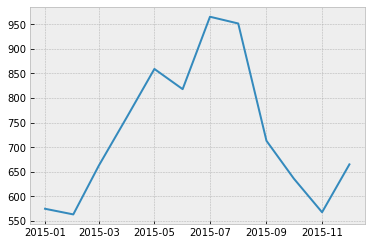

In [63]:
### Forecasting for the next 12 Time Period
plt.plot(Forecasting12_SARIMAX)
plt.show()